## Demonstration of spectral analysis of CH-2 XSM data with pyxspec: Isothermal models

##### Mithun N P S, PRL Ahmedabad 
##### Contact: xsmpoc@prl.res.in

This notebook demonstrates spectral fitting of Chandrayaan-2 XSM observations of a flare in PyXSPEC. Fitting with two isothermal models namely *vvapec* (AtomDB based) and *chisoth* (CHIANTI based) are shown. 

#### Pre-requisites


* Download the data for 01-10-2019 from XSM data archive at https://pradan.issdc.gov.in/ch2/ and unzip the file *ch2_xsm_20191001_v1.zip* in the present working directory. 

* Install XSMDAS: XSM data analysis software in your system along with CALDB (see Section 3 of suer guide at https://www.prl.res.in/ch2xsm/static/ch2_xsm_data_analysis_guide.pdf).

* Install XSPEC which is part of heasoft which will also build the python binding pyxspec. See https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/python/html/buildinstall.html for instructions 

* Python packages astropy, matplotlib, numpy, corner (in addition to some standard packages) are required for some specific parts 

* Local model distribution of chisoth is required for fitting with that model. This will be soon made available publicaly.

Data during the peak of B-class flare on 01-10-2019 around 01:45 UTC is used here. Light curve of the flare from XSM website (https://www.prl.res.in/ch2xsm/).
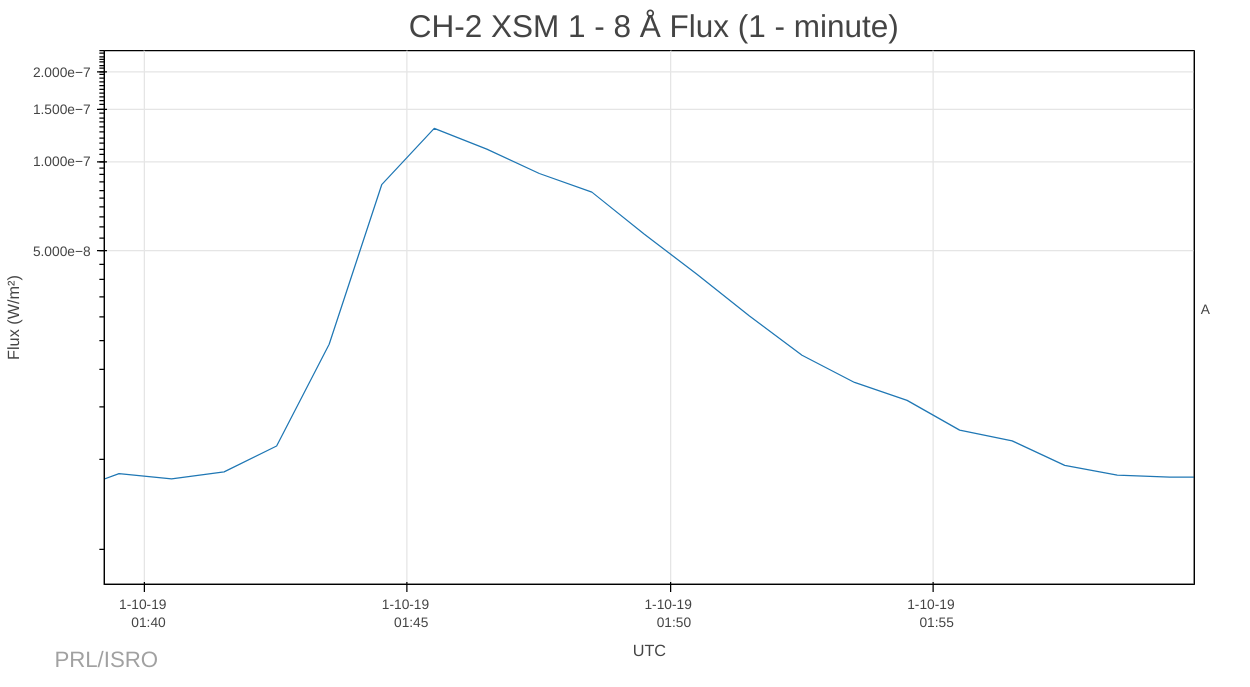

In [1]:
# Imports

from xspec import *

from datetime import datetime
import os
import numpy as np
from astropy.io import fits
import corner
import matplotlib.pyplot as plt


#### Generate spectrum using XSMDAS

We generate spectrum for three minute duration from 01:44 to 01:47 UTC using **xsmgenspec** task. Note that this can be done in loop to generate spectra for different time bins etc. 

 After these two steps, proceed with this notebook. 

In [2]:


tref=datetime(2017,1,1)
tstart=(datetime(2019,10,1,1,44)-tref).total_seconds()
tstop=(datetime(2019,10,1,1,47)-tref).total_seconds()

l1dir='xsm/data/2019/10/01/raw/'
l2dir='xsm/data/2019/10/01/calibrated/'

base='ch2_xsm_20191001_v1'

l1file=l1dir+'/'+base+'_level1.fits'
hkfile=l1dir+'/'+base+'_level1.hk'
safile=l1dir+'/'+base+'_level1.sa'
gtifile=l2dir+'/'+base+'_level2.gti'

specbase='ch2_xsm_20191001_0144-0147'
specfile=specbase+'.pha'

genspec_command="xsmgenspec l1file="+l1file+" specfile="+specfile+" spectype='time-integrated'"+ \
" tstart="+str(tstart)+" tstop="+str(tstop)+" hkfile="+hkfile+" safile="+safile+" gtifile="+gtifile

s=os.system(genspec_command)


-------------------------------------------------------------------------
  XSMDAS: Data Analysis Software for Chandrayaan-II Solar X-ray Monitor  
                     XSMDAS Version: 1.2              
                     Module : XSMGENSPEC                        
-------------------------------------------------------------------------
------------------------------------------------------------------------
MESSAGE: Ebounds CALDB file used is: /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmebounds20191214v01.fits
MESSAGE: Gain CALDB file used is: /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmgain20200330v03.fits
MESSAGE: Abscoef CALDB file used is: /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmabscoef20200410v01.fits
MESSAGE: Effareapar CALDB file used is: /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmeffareapar20210423v02.fits
MESSAGE: Syserror CALDB file used is: /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmsyserr2020041

#### Load spectrum in XSPEC and plot

Spectrum is loaded in XSPEC and plotted using XSPEC's plotting options. It is also possible to use matplotlib or other python libraries to plot the spectrum. How to ignore certain energy ranges for further analysis is also shown.

In [3]:

# Clear any previously loaded data and models

AllData.clear()
AllModels.clear()

# Load spectrum (ARF, RMF, background etc will be loaded automatically if specified in spectrum header)
spec = Spectrum(specfile)


# Set plot device, x-axis to energy instead of channel, plot spectrum
Plot.device = '/xw'    
Plot.xAxis = 'keV'

Plot('ld')



1 spectrum  in use
 
Spectral Data File: ch2_xsm_20191001_0144-0147.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.336e+02 +/- 1.946e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-512
  Telescope: CH-2_ORBITER Instrument: CH2_XSM  Channel Type: PI
  Exposure Time: 180 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmresponse20200423v01.rmf for Source 1
 Using Auxiliary Response (ARF) File  ch2_xsm_20191001_0144-0147.arf



We need to ignore spectrum below 1.3  keV (response not well known) and above 4.2 keV where there are not many counts above background, before proceeding to spectral fitting. 



In [4]:
spec.ignore("**-1.3 4.2-**")
Plot('ld')

    25 channels (1-25) ignored in spectrum #     1
   400 channels (113-512) ignored in spectrum #     1



It is possible to extend the spectral fitting to higher energies by rebinning the spectrum so that there are more counts in each channel. This can be done using the HEASOFT FTOOL task **grppha**. This is required if one uses chisquare statistics for fitting which assumes Gaussian errors on the counts in each channel. Another option is to use other statistics such as cstat which does not make such assumptions

#### Fitting spectrum with vvapec model

Now, we fit the spectrum in the selected energy range using vvapec model.

In [5]:
# define the model
m1 = Model("vvapec")

# do the fit
Fit.perform()

# plot data, model and del-chi
Plot('ld','delc')


Model vvapec<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   vvapec     kT         keV      6.50000      +/-  0.0          
   2    1   vvapec     H                   1.00000      frozen
   3    1   vvapec     He                  1.00000      frozen
   4    1   vvapec     Li                  1.00000      frozen
   5    1   vvapec     Be                  1.00000      frozen
   6    1   vvapec     B                   1.00000      frozen
   7    1   vvapec     C                   1.00000      frozen
   8    1   vvapec     N                   1.00000      frozen
   9    1   vvapec     O                   1.00000      frozen
  10    1   vvapec     F                   1.00000      frozen
  11    1   vvapec     Ne                  1.00000      frozen
  12    1   vvapec     Na                  1.00000      frozen
  13    1   vvapec     Mg                  1.00000      frozen
  14    1   vvapec     Al                  1.00000      frozen
  1

In [6]:
# Free some parameters that are frozen (Mg, Si, and S)
m1.show()

m1.vvapec.Mg.frozen=False
m1.vvapec.Si.frozen=False
m1.vvapec.S.frozen=False

## Note: Abundances of other elements also should be set to coronal values as required. 
##       Default abundances in apec are not coronal

# Fit spectrum again
Fit.perform()

Plot('ld','delc')

    1   vvapec     Ne                  1.00000      frozen
  12    1   vvapec     Na                  1.00000      frozen
  13    1   vvapec     Mg                  1.00000      frozen
  14    1   vvapec     Al                  1.00000      frozen
  15    1   vvapec     Si                  1.00000      frozen
  16    1   vvapec     P                   1.00000      frozen
  17    1   vvapec     S                   1.00000      frozen
  18    1   vvapec     Cl                  1.00000      frozen
  19    1   vvapec     Ar                  1.00000      frozen
  20    1   vvapec     K                   1.00000      frozen
  21    1   vvapec     Ca                  1.00000      frozen
  22    1   vvapec     Sc                  1.00000      frozen
  23    1   vvapec     Ti                  1.00000      frozen
  24    1   vvapec     V                   1.00000      frozen
  25    1   vvapec     Cr                  1.00000      frozen
  26    1   vvapec     Mn                  1.00000      fro

In [7]:
# Show best-fit  parameters
m1.show()

vapec     B                   1.00000      frozen
   7    1   vvapec     C                   1.00000      frozen
   8    1   vvapec     N                   1.00000      frozen
   9    1   vvapec     O                   1.00000      frozen
  10    1   vvapec     F                   1.00000      frozen
  11    1   vvapec     Ne                  1.00000      frozen
  12    1   vvapec     Na                  1.00000      frozen
  13    1   vvapec     Mg                  1.22620      +/-  0.127082     
  14    1   vvapec     Al                  1.00000      frozen
  15    1   vvapec     Si                  1.46958      +/-  9.18203E-02  
  16    1   vvapec     P                   1.00000      frozen
  17    1   vvapec     S                   0.905206     +/-  7.56321E-02  
  18    1   vvapec     Cl                  1.00000      frozen
  19    1   vvapec     Ar                  1.00000      frozen
  20    1   vvapec     K                   1.00000      frozen
  21    1   vvapec     Ca       

Compute errors on the best fit parameters

In [8]:
Fit.error("1.0 1,13,15,17,33")

 Parameter   Confidence Range (1)
     1     0.633138     0.660144    (-0.0147058,0.0123007)
    13      1.09141      1.36685    (-0.135126,0.140313)
    15      1.37527      1.57199    (-0.0945164,0.102204)
    17     0.830279     0.982582    (-0.0748777,0.0774255)
    33       449386       519802    (-32053.4,38362.6)


#### Fitting spectrum with chisoth model

Alternatively, we can fit the spectrum using chisoth model that is based on CHIANTI database (Mondal et al, 2021, ApJ) available in chspec package. 

This is a local model that needs to be loaded in XSPEC (not available by default) before using.
The model is available at https://github.com/xastprl/chspec

In [9]:
# Load chisoth model 
basepathmod='/home/mithun/work/ch2/xsm/science/chspec/'
AllModels.lmod('chspec',dirPath=basepathmod)

Model package isoth successfully loaded.


In [10]:
# Set chisoth as model and do fit, free abundances, fit again.

m1 = Model("chisoth")

Fit.perform()
Plot('ld','delc')

# Another way to access the model object, and parameters
# m1==Allmode
m1(12).frozen=False
m1(14).frozen=False
m1(16).frozen=False

Fit.perform()
Plot('ld','delc')


Model chisoth<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   chisoth    Log10T     K        6.39000      +/-  0.0          
   2    1   chisoth    He                  10.9000      frozen
   3    1   chisoth    Li                  1.64000      frozen
   4    1   chisoth    Be                  1.94000      frozen
   5    1   chisoth    B                   3.09000      frozen
   6    1   chisoth    C                   8.59000      frozen
   7    1   chisoth    N                   8.00000      frozen
   8    1   chisoth    O                   8.89000      frozen
   9    1   chisoth    F                   4.56000      frozen
  10    1   chisoth    Ne                  8.08000      frozen
  11    1   chisoth    Na                  6.93000      frozen
  12    1   chisoth    Mg                  8.15000      frozen
  13    1   chisoth    Al                  7.04000      frozen
  14    1   chisoth    Si                  8.10000      frozen
  

In [11]:
AllModels.show(parIDs="1 12 14 16 31")
Fit.error("1.0 1 12 14 16 31")


  -2.827e-06   7.069e-04   4.371e-04   1.098e-03  -7.423e-03
  -2.540e-03  -1.956e-02  -1.092e-02  -7.423e-03   2.769e-01
------------------------------------------------------------

Model chisoth<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   chisoth    Log10T     K        6.90753      +/-  6.18177E-03  
   2    1   chisoth    He                  10.9000      frozen
   3    1   chisoth    Li                  1.64000      frozen
   4    1   chisoth    Be                  1.94000      frozen
   5    1   chisoth    B                   3.09000      frozen
   6    1   chisoth    C                   8.59000      frozen
   7    1   chisoth    N                   8.00000      frozen
   8    1   chisoth    O                   8.89000      frozen
   9    1   chisoth    F                   4.56000      frozen
  10    1   chisoth    Ne                  8.08000      frozen
  11    1   chisoth    Na                  6.93000      frozen
  12   

In [12]:
# Save the fit details to xcm file 

fxcm=specbase+'_chisoth_Fit.xcm'

# Caution!!: remove previous xcm file
if (os.path.isfile(fxcm)):
    os.remove(fxcm)
    
Xset.save(fxcm)

#### Plot Spectrum, model, residuals using matplotlib

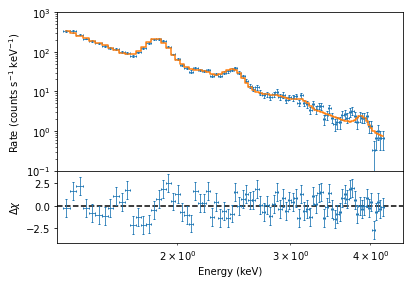

In [13]:
Plot('ld','delc')

ene=Plot.x(plotGroup=1, plotWindow=1)
eneErr=Plot.xErr(plotGroup=1, plotWindow=1)
spec=Plot.y(plotGroup=1, plotWindow=1)
specErr=Plot.yErr(plotGroup=1, plotWindow=1)
        
fitmodel=Plot.model(plotGroup=1, plotWindow=1)
        
delchi=Plot.y(plotGroup=1, plotWindow=2)
delchiErr=Plot.yErr(plotGroup=1, plotWindow=2)

fig0 = plt.figure(num=None, figsize=(6, 4), facecolor='w', edgecolor='k')
        
ax0 = fig0.add_axes([0.15, 0.4, 0.8, 0.55])
ax0.xaxis.set_visible(False)
plt.errorbar(ene,spec,xerr=eneErr,yerr=specErr,fmt='.',ms=0.5,capsize=1.0,lw=0.8)
plt.step(ene,fitmodel,where='mid')
plt.yscale("log")
plt.xscale("log")
plt.xlim([1.3,4.5])
plt.ylim([0.1,1e3])
plt.ylabel('Rate (counts s$^{-1}$ keV$^{-1}$)')


ax1 = fig0.add_axes([0.15, 0.15, 0.8, 0.25])
plt.axhline(0,linestyle='dashed',color='black')
plt.errorbar(ene,delchi,xerr=eneErr,yerr=delchiErr,fmt='.',ms=0.1,capsize=1.0,lw=0.8)
plt.xscale("log")
plt.xlim([1.3,4.5])         
plt.ylabel('$\Delta \chi$')

plt.xlabel('Energy (keV)')


plt.show()
plt.close()



#### MCMC analysis with chisoth model

In [14]:
# Clear previous data/model

AllModels.clear()
AllData.clear()

# Restore the fit details from xcm file (load data, define model with selected free par)
Xset.restore(fxcm)

Fit.perform()

# Store best fit parameters to variable

nfreepar=5
freepar=[1,12,14,16,31]
fitpar=np.zeros(nfreepar)
    
for j in range(0,nfreepar):
    fitpar[j]=AllModels(1)(freepar[j]).values[0]


Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

1 spectrum  in use
 
Spectral Data File: ch2_xsm_20191001_0144-0147.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.336e+02 +/- 1.946e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-512
  Telescope: CH-2_ORBITER Instrument: CH2_XSM  Channel Type: PI
  Exposure Time: 180 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/mithun/work/ch2/xsm/pipeline/XSM/xsmdas/caldb/CH2xsmresponse20200423v01.rmf for Source 1
 Using Auxiliary Response (ARF) File  ch2_xsm_20191001_0144-0147.arf

    25 channels (1,25) ignored in spectrum #     1
   400 channels (113,512) ignored in spectrum #     1

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue
 Mode

In [15]:
#Clear existing chains

AllChains -= '*'

# run mcmc chain
chainfile=specbase+'_chsioth_chain.fits'

runLength=10000
burn=500

# run again only if previous run output not stored in file
if (not os.path.isfile(chainfile)):
    Chain(chainfile, burn=burn, runLength=runLength, rand=True, algorithm='gw', walkers=8)
else:
    AllChains +=chainfile


   All chains are now removed.
  New chain ch2_xsm_20191001_0144-0147_chsioth_chain.fits is now loaded.
  Default chain length is now set to length of ch2_xsm_20191001_0144-0147_chsioth_chain.fits: 10000
  Default walkers length is now set to: 8


Plot chain outputs using XSPEC plot commands

In [16]:
Plot('chain 0')

In [17]:
Plot('chain 1')

In [18]:
Plot('chain 12')

In [19]:
Plot('chain 1 31')

Compute errors using MCMC chain

In [20]:
Fit.error("1.0 1 12 14 16 31")

Errors calculated from chains
 Parameter   Confidence Range (1)
     1      6.90033       6.9134    (-0.00720205,0.00587378)
    12      7.70558      7.78654    (-0.0453361,0.0356187)
    14       7.8079      7.85826    (-0.0271128,0.0232471)
    16       7.2418      7.30177    (-0.0300385,0.029929)
    31      9.53061      10.5707    (-0.458032,0.582017)


Use corner.py  to get corner plots of MCMC result

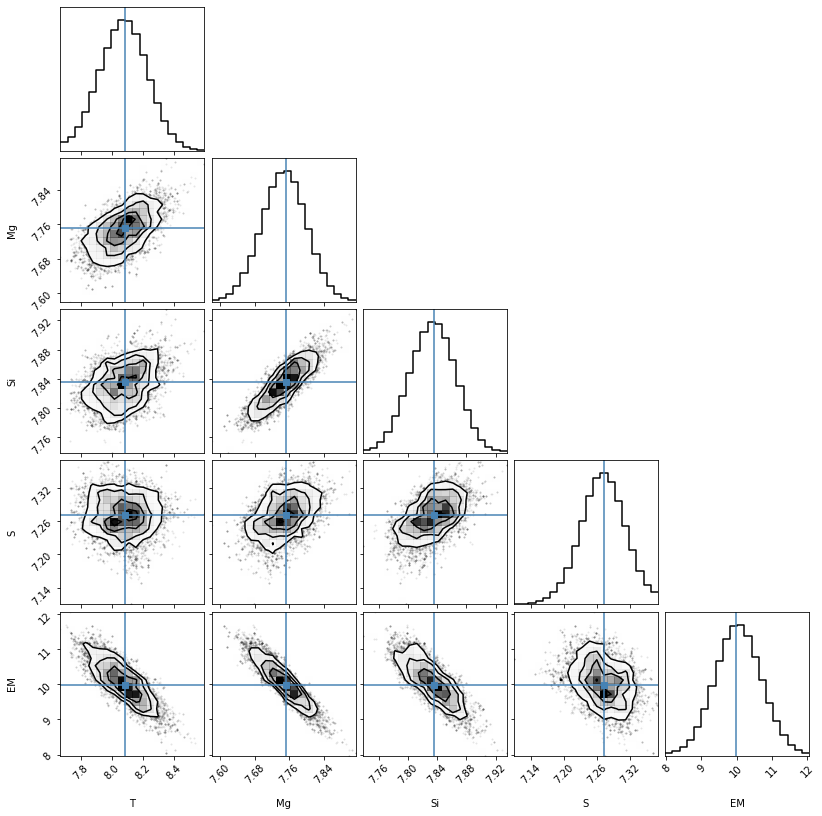

In [21]:
fhdu = fits.open(chainfile)
fdata = fhdu[1].data
T=fdata['Log10T__1']
EM=fdata['norm__31']

allpar=[10**(T-6.0),fdata['Mg__12'],fdata['Si__14'],fdata['S__16'],EM]
pbest=np.array(fitpar)
pbest[0]=10**(pbest[0]-6.0)
params=['T','Mg','Si','S','EM']

fig1=corner.corner(np.transpose(allpar),truths=pbest,smooth1d=2,labels=params,bins=20)
plt.show()
plt.close()

